In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from tensorflow.python.keras.callbacks import EarlyStopping

train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복 리뷰 삭제
    train_data = train_data.dropna(how = 'any') # Null 샘플 제거
    test_data.drop_duplicates(subset=['document'], inplace=True) 
    test_data = test_data.dropna(how = 'any') 

    x_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_train.append(temp_x)

    x_test = []
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_test.append(temp_x)

    # 정수로 인코딩
    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)    
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # enumerate 열거하다

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data) # load_data

print(len(x_train))
print(len(x_test))

146182
49157


In [2]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [3]:
total_data_text = list(x_train) + list(x_test)
# 텍스트 데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + round(2.5 * np.std(num_tokens))
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)*100 / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  47
전체 문장의 95.2175448835102%가 maxlen 설정값 이내에 포함됩니다. 


In [4]:
# 위의 maxlen 값에 맞춰서 패딩
# post는 data 뒤에 패딩, pre는 data 앞에 패딩
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                      value=word_to_index["<PAD>"],
                                                      padding='pre',
                                                      maxlen=maxlen)

In [5]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 8  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

#GlobalMaxPooling1D() 레이어 하나만 사용하는 방법
#전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식
model_GlobMP = keras.Sequential()
model_GlobMP.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_GlobMP.add(keras.layers.GlobalMaxPooling1D())
#model_GlobMP.add(keras.layers.Dropout(0.3))
model_GlobMP.add(keras.layers.Dense(8, activation='relu'))
#model_GlobMP.add(keras.layers.Dropout(0.3))
model_GlobMP.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

In [28]:
print('GlobMP---------------------------------------------------------------------------------------------------')
model_GlobMP.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

callbacks_list = [
    # 검증 정확도(val_loss)가 10 epoch보다 더 긴시간동안 향상되지 않으면 훈련을 중지
    EarlyStopping(monitor='val_loss', # 기본값은 monitor='val_loss'
                  patience=5),
    
    # 훈련 중 검증 손실(val_loss)이 가장 좋을 때마다 계속해서 저장
    # (최종적으로 가장 좋은 모델만 저장됨)
    ModelCheckpoint(filepath='my_model_GlobMP.h5',
                    monitor='val_loss',
                    save_best_only=True)]

history_model_GlobMP = model_GlobMP.fit(x_train, 
                                        y_train, 
                                        epochs=10, 
                                        callbacks=callbacks_list, 
                                        batch_size=100, 
                                        validation_split=0.2)

GlobMP---------------------------------------------------------------------------------------------------
Epoch 1/10
1170/1170 [==============================] - 1s 1ms/step - loss: 0.3391 - acc: 0.8564 - val_loss: 0.3734 - val_acc: 0.8387
Epoch 2/10
1170/1170 [==============================] - 1s 1ms/step - loss: 0.3374 - acc: 0.8570 - val_loss: 0.3736 - val_acc: 0.8384
Epoch 3/10
1170/1170 [==============================] - 1s 1ms/step - loss: 0.3360 - acc: 0.8577 - val_loss: 0.3742 - val_acc: 0.8379
Epoch 4/10
1170/1170 [==============================] - 1s 1ms/step - loss: 0.3348 - acc: 0.8585 - val_loss: 0.3733 - val_acc: 0.8387
Epoch 5/10
1170/1170 [==============================] - 1s 1ms/step - loss: 0.3336 - acc: 0.8594 - val_loss: 0.3739 - val_acc: 0.8388
Epoch 6/10
1170/1170 [==============================] - 1s 1ms/step - loss: 0.3326 - acc: 0.8600 - val_loss: 0.3729 - val_acc: 0.8389
Epoch 7/10
1170/1170 [==============================] - 1s 1ms/step - loss: 0.3315 - acc: 

In [36]:
loaded_model_GlobMP = load_model('best_model_GlobMP.h5')
results_GlobMP = loaded_model_GlobMP.evaluate(x_test, y_test)[1]
print(results_GlobMP)

1537/1537 [==============================] - 1s 582us/step - loss: 0.3829 - acc: 0.8330
0.8329840898513794


In [10]:
# # test 는 "evaluate"
# results_GlobMP = model_GlobMP.evaluate(x_test,  y_test, verbose=2, callbacks=callbacks_list)

# print(results_GlobMP)

1537/1537 - 1s - loss: 0.3786 - acc: 0.8351
[0.37861162424087524, 0.8351201415061951]


In [30]:
history_dict_GlobMP = history_model_GlobMP.history
print(history_dict_GlobMP.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


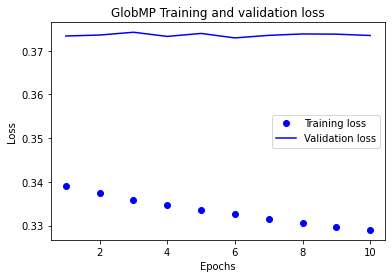

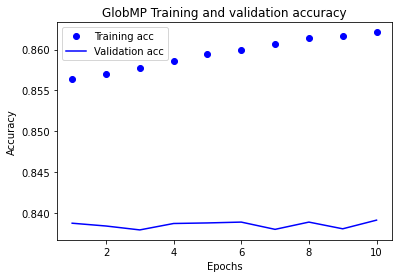

In [31]:
import matplotlib.pyplot as plt
# GlobMP
acc = history_dict_GlobMP['acc']
val_acc = history_dict_GlobMP['val_acc']
loss = history_dict_GlobMP['loss']
val_loss = history_dict_GlobMP['val_loss']

epochs = range(1, len(acc) + 1)

#fig, ax = plt.subplots(1, 2, sharex=True) 
# fig란 figure로써 - 전체 subplot을 말한다. 
# ex) 서브플로안에 몇개의 그래프가 있던지 상관없이  그걸 담는 하나.전체 사이즈를 말한다.
# ax는 axe로써 - 전체 중 낱낱개를 말한다 
# ex) 서브플롯 안에 2개(a1,a2)의 그래프가 있다면 a1, a2 를 일컬음


# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('GlobMP Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('GlobMP Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [32]:
# GLobMP
embedding_layer = model_GlobMP.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 8)


In [37]:
import os

# 학습한 GlobMP Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_GlobMP = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_GlobMP.txt'
f = open(word2vec_file_path_GlobMP, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_GlobMP.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [38]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors_GlobMP = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_GlobMP, binary=False)
vector_GlobMP = word_vectors_GlobMP['팝콘']
vector_GlobMP

ValueError: invalid vector on line 0 (is this really the text format?)

In [16]:
word_vectors_GlobMP.similar_by_word('팝콘')

[('똥폼', 0.9835149049758911),
 ('답답', 0.9819633960723877),
 ('쳐라', 0.9804656505584717),
 ('아닙니까', 0.9776525497436523),
 ('따분', 0.9714463949203491),
 ('모를까', 0.9688930511474609),
 ('행위', 0.9604905843734741),
 ('쌍욕', 0.9596959352493286),
 ('쓸데없이', 0.9583407044410706),
 ('돈', 0.9573423862457275)]

In [19]:
from gensim.models import KeyedVectors
import os
import gensim

ko_model = gensim.models.Word2Vec.load('./sentiment_classification/ko.bin')
word2vec = ko_model
vector = ko_model['강아지']
len(vector)

/home/aiffel-dj35/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


200

In [21]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel-dj35/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel-dj35/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [22]:
from tensorflow.keras.initializers import Constant
# model 설계

#LSTM
# model_LSTM2 = Sequential()
# model_LSTM2.add(keras.layers.Embedding(vocab_size, 
#                                  word_vector_dim, 
#                                  embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
#                                  input_length=maxlen, 
#                                  trainable=True))   # trainable을 True로 주면 Fine-tuning
# model_LSTM2.add(LSTM(128))
# model_LSTM2.add(Dense(1, activation='sigmoid'))


#GlobalMaxPooling1D() 레이어 하나만 사용하는 방법
#전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식
model_GlobMP2 = keras.Sequential()
model_GlobMP2.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model_GlobMP2.add(keras.layers.GlobalMaxPooling1D())
#model_GlobMP2.add(keras.layers.Dropout(0.3))
model_GlobMP2.add(keras.layers.Dense(8, activation='relu'))
#model_GlobMP2.add(keras.layers.Dropout(0.3))
model_GlobMP2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


# model_LSTM2.summary()
model_GlobMP2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 47, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [24]:
print('GlobMP---------------------------------------------------------------------------------------------------')
model_GlobMP2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

callbacks_list = [
    # 검증 정확도(val_loss)가 10 epoch보다 더 긴시간동안 향상되지 않으면 훈련을 중지
    EarlyStopping(monitor='val_loss', # 기본값은 monitor='val_loss'
                  patience=5),
    
    # 훈련 중 검증 손실(val_loss)이 가장 좋을 때마다 계속해서 저장
    # (최종적으로 가장 좋은 모델만 저장됨)
    ModelCheckpoint(filepath='my_model.h5',
                    monitor='val_loss',
                    save_best_only=True)]

history_model_GlobMP2 = model_GlobMP2.fit(x_train, 
                                        y_train, 
                                        epochs=10, 
                                        callbacks=callbacks_list, 
                                        batch_size=100, 
                                        validation_split=0.2)

GlobMP---------------------------------------------------------------------------------------------------
Epoch 1/10
1170/1170 [==============================] - 11s 10ms/step - loss: 0.6026 - acc: 0.6701 - val_loss: 0.5932 - val_acc: 0.6914
Epoch 2/10
1170/1170 [==============================] - 11s 9ms/step - loss: 0.5003 - acc: 0.7544 - val_loss: 0.4764 - val_acc: 0.7718
Epoch 3/10
1170/1170 [==============================] - 11s 10ms/step - loss: 0.4571 - acc: 0.7836 - val_loss: 0.4657 - val_acc: 0.7768
Epoch 4/10
1170/1170 [==============================] - 10s 9ms/step - loss: 0.4311 - acc: 0.7992 - val_loss: 0.4783 - val_acc: 0.7749
Epoch 5/10
1170/1170 [==============================] - 12s 10ms/step - loss: 0.4124 - acc: 0.8110 - val_loss: 0.4244 - val_acc: 0.8030
Epoch 6/10
1170/1170 [==============================] - 13s 11ms/step - loss: 0.3981 - acc: 0.8193 - val_loss: 0.4139 - val_acc: 0.8104
Epoch 7/10
1170/1170 [==============================] - 11s 9ms/step - loss: 0.3

In [26]:
# test 는 "evaluate"
results_GlobMP2 = model_GlobMP2.evaluate(x_test,  y_test, verbose=2, callbacks=callbacks_list)

print(results_GlobMP2)

1537/1537 - 1s - loss: 0.4506 - acc: 0.7909
[0.4506412744522095, 0.7909351587295532]


In [27]:
print('Before :',results_GlobMP)
print('--------------------------------------------')
print('After :',results_GlobMP2)

Before : [0.37861162424087524, 0.8351201415061951]
--------------------------------------------
After : [0.4506412744522095, 0.7909351587295532]
